In [ ]:
# Step 1: Install Kaggle API
!pip install -q kaggle

# Step 2: Upload the kaggle.json API key manually or using the following code
from google.colab import files
files.upload()  # Upload your kaggle.json

# Step 3: Set up Kaggle API credentials
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)

# Step 4: Download the dataset
!kaggle datasets download -d andrewmvd/animal-faces

# Step 5: Unzip the dataset if necessary
!unzip /content/animal-faces.zip -d /content/animal_faces

Streaming output truncated to the last 5000 lines.
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001378.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001379.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001380.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001381.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001382.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001384.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001385.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001386.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001387.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001388.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001389.jpg  
  inflating: /content/animal_faces/afhq/train/wild/flickr_wild_001390.jpg  
  inflating: /content/animal_faces/af

In [ ]:
pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from flask import Flask, request, jsonify, render_template
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch

# Step 1: Data Preprocessing
data_dir = "/content/animal_faces/afhq"
img_size = 128
batch_size = 32

# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, "val"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


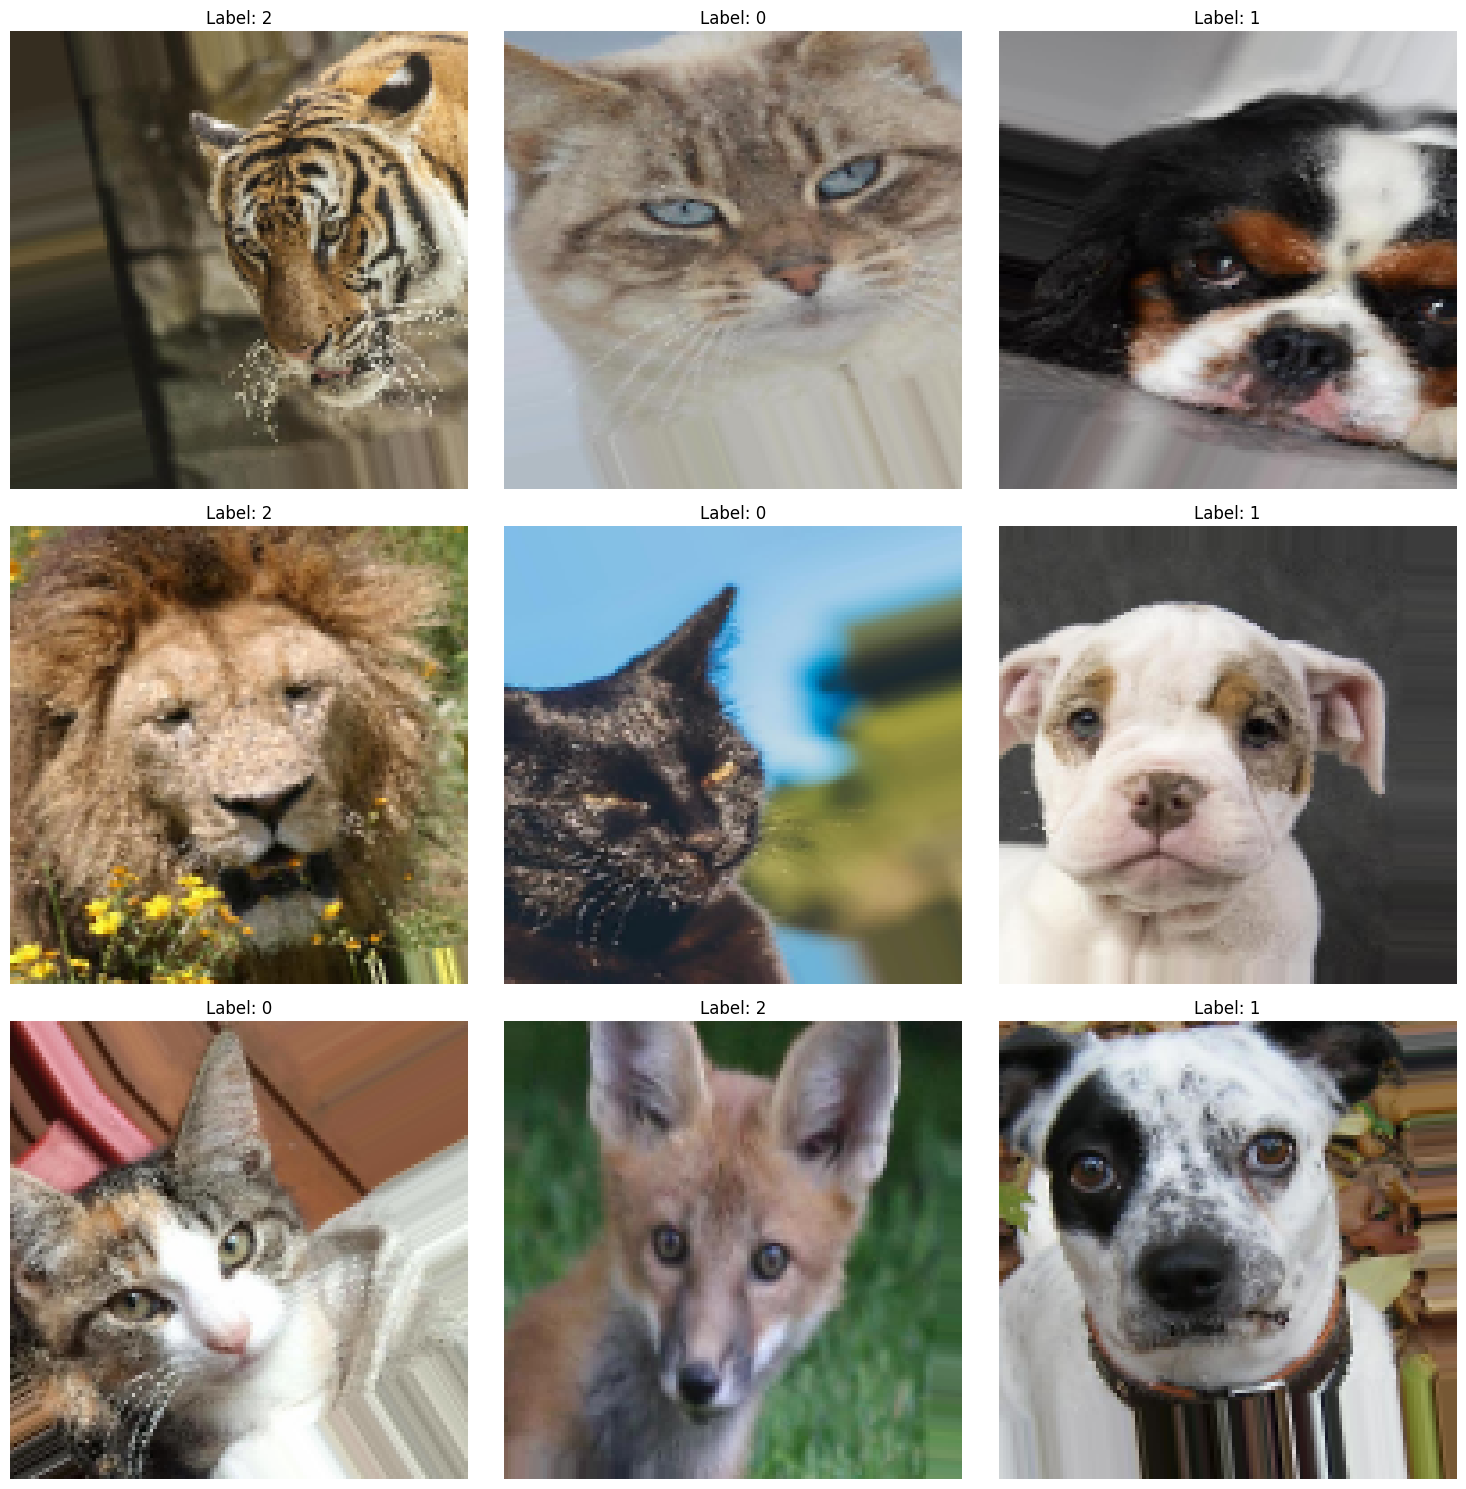

In [ ]:
# Step 2: Visualize Preprocessed Images
def visualize_preprocessed_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(15, 15))
    for i in range(min(len(images), 9)):  # Display up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display preprocessed images
visualize_preprocessed_images(train_generator)

In [ ]:

# Step 3: Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes: cat, dog, wild
])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping]
)



Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


458/458 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.5024 - loss: 0.9658 - val_accuracy: 0.7773 - val_loss: 0.5288
Epoch 2/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 654s 1s/step - accuracy: 0.7626 - loss: 0.5777 - val_accuracy: 0.8647 - val_loss: 0.3930
Epoch 3/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - accuracy: 0.8396 - loss: 0.4221 - val_accuracy: 0.8647 - val_loss: 0.4365
Epoch 4/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.8748 - loss: 0.3365 - val_accuracy: 0.9473 - val_loss: 0.1583
Epoch 5/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.8984 - loss: 0.2742 - val_accuracy: 0.9513 - val_loss: 0.1338
Epoch 6/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 585s 1s/step - accuracy: 0.9073 - loss: 0.2533 - val_accuracy: 0.9620 - val_loss: 0.1056
Epoch 7/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.9151 - loss: 0.2264 - val_accuracy: 0.9533 - val_loss: 0.1627
Epoch 8/25
458/458 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.9280 - loss: 0.2007 - val_accuracy: 0.953

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.9872 - loss: 0.0429
Validation Loss: 0.0439, Validation Accuracy: 0.9867


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


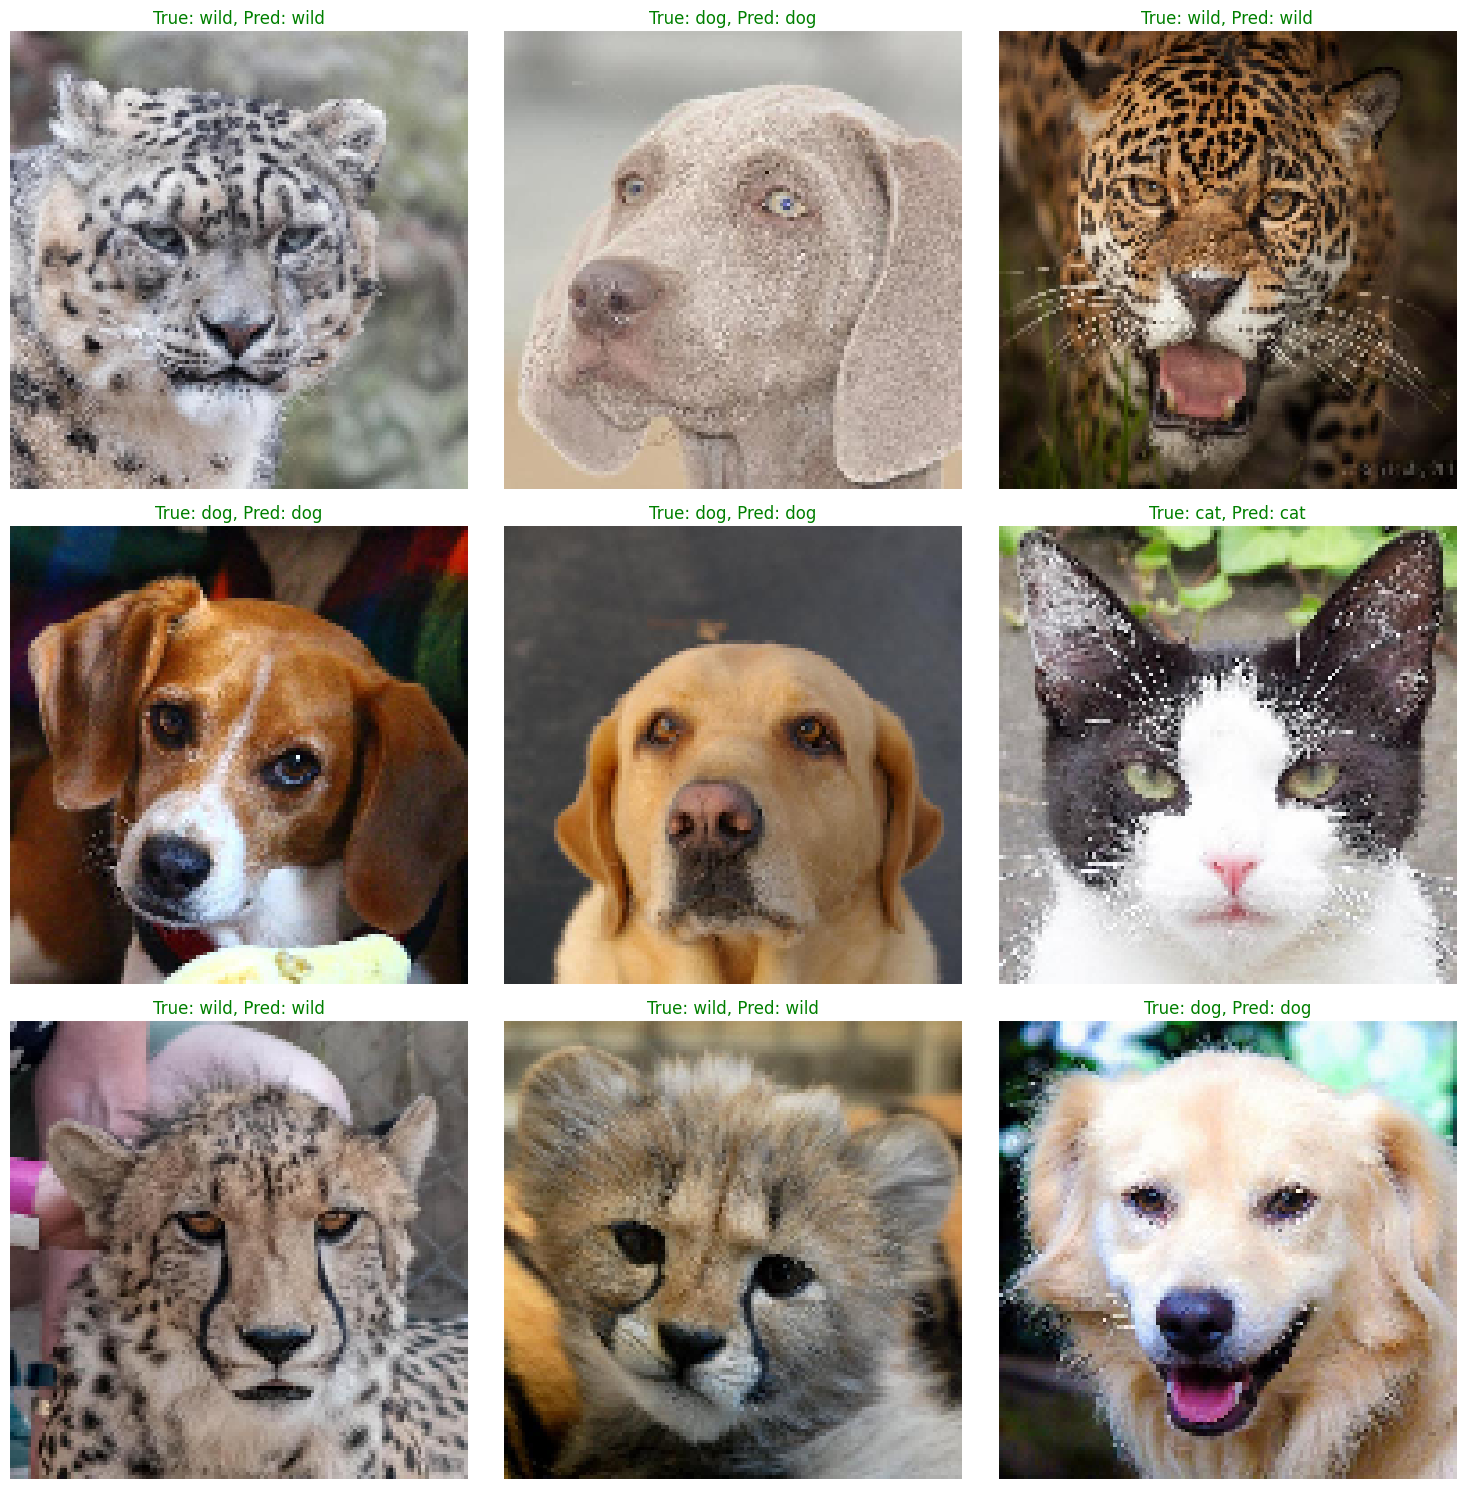

47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.9831 - loss: 0.0487
Validation Loss: 0.0439, Validation Accuracy: 0.9867


In [ ]:

# Step 5: Visualize Predictions
def visualize_predictions(model, generator, class_indices):
    reverse_class_indices = {v: k for k, v in class_indices.items()}
    images, labels = next(generator)
    predictions = model.predict(images)

    plt.figure(figsize=(15, 15))
    for i in range(min(len(images), 9)):  # Display up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = reverse_class_indices[np.argmax(labels[i])]
        predicted_label = reverse_class_indices[np.argmax(predictions[i])]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}, Pred: {predicted_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_generator, train_generator.class_indices)

# Step 6: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
def predict_image(image_path, model, class_indices):
    reverse_class_indices = {v: k for k, v in class_indices.items()}
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_label = reverse_class_indices[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return predicted_label, confidence

# Example usage
test_image_path = "/content/animal_faces/afhq/val/dog/flickr_dog_000079.jpg"
label, confidence = predict_image(test_image_path, model, train_generator.class_indices)
print(f"Predicted Label: {label}, Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Predicted Label: dog, Confidence: 99.94%


In [ ]:
def predict_image(image_path, model, class_indices):
    reverse_class_indices = {v: k for k, v in class_indices.items()}
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_label = reverse_class_indices[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return predicted_label, confidence

# Example usage
test_image_path = "/content/animal_faces/afhq/val/wild/flickr_wild_000075.jpg"
label, confidence = predict_image(test_image_path, model, train_generator.class_indices)
print(f"Predicted Label: {label}, Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label: wild, Confidence: 64.66%


In [ ]:
model.save("animal_model.h5")


In [1]:
!pip install pyngrok


In [2]:

from pyngrok import ngrok

# Set your ngrok authtoken
ngrok.set_auth_token("2sAS7yHBpbbFZcQD2GcUdaLOCgO_3fM2kKzd1jjPhzCMvbouz")


In [11]:
import os
import numpy as np
from flask import Flask, request, render_template_string, url_for
from pyngrok import ngrok
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from werkzeug.utils import secure_filename
import h5py

# Initialize Flask app
app = Flask(__name__)
UPLOAD_FOLDER = "static/uploads"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config["UPLOAD_FOLDER"] = UPLOAD_FOLDER

# Check if model file exists and is valid
model_path = "/content/animal_model.h5"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please upload the model file.")

try:
    with h5py.File(model_path, "r") as f:
        print("Model file is valid and readable.")
except Exception as e:
    raise ValueError(f"Error reading the model file: {e}")

# Load the trained model
model = load_model(model_path)
print("Model loaded successfully.")

# Define class labels
class_labels = {0: "Cat", 1: "Dog", 2: "Wild Animal"}
confidence_threshold = 0.7  # Confidence threshold for valid predictions

# HTML Template
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Animal Classification System</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f9;
            color: #333;
            margin: 0;
            padding: 0;
        }
        header {
            background-color: #4CAF50;
            color: white;
            padding: 20px;
            text-align: center;
        }
        main {
            max-width: 600px;
            margin: 30px auto;
            padding: 20px;
            background: white;
            border-radius: 8px;
            box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
        }
        h1 {
            margin-bottom: 20px;
            color: #4CAF50;
        }
        form {
            margin: 20px 0;
            display: flex;
            flex-direction: column;
            align-items: center;
        }
        form input {
            margin: 10px 0;
        }
        form button {
            background-color: #4CAF50;
            color: white;
            border: none;
            padding: 10px 20px;
            font-size: 16px;
            border-radius: 5px;
            cursor: pointer;
        }
        form button:hover {
            background-color: #388E3C;
        }
        .result {
            text-align: center;
            margin-top: 20px;
        }
        .result img {
            max-width: 300px;
            margin-top: 20px;
            border: 2px solid #ddd;
            border-radius: 8px;
        }
        .warning {
            color: red;
            font-weight: bold;
        }
        footer {
            text-align: center;
            padding: 10px;
            background: #4CAF50;
            color: white;
            margin-top: 20px;
        }
    </style>
</head>
<body>
    <header>
        <h1>Animal Classification System</h1>
    </header>
    <main>
        <form action="/" method="post" enctype="multipart/form-data">
            <input type="file" name="file" accept="image/*" required>
            <button type="submit">Upload and Predict</button>
        </form>
        {% if label %}
        <div class="result">
            <h2>Prediction: {{ label }}</h2>
            <img src="{{ image_url }}" alt="Uploaded Image">
        </div>
        {% endif %}
        {% if warning %}
        <div class="result warning">
            <h2>{{ warning }}</h2>
        </div>
        {% endif %}
    </main>
    <footer>

    </footer>
</body>
</html>
"""

@app.route("/", methods=["GET", "POST"])
def home():
    if request.method == "POST":
        # Handle file upload
        file = request.files.get("file")
        if file:
            # Save the uploaded file
            filename = secure_filename(file.filename)
            file_path = os.path.join(app.config["UPLOAD_FOLDER"], filename)
            file.save(file_path)

            # Preprocess the image
            image = load_img(file_path, target_size=(128, 128))
            image_array = img_to_array(image) / 255.0  # Normalize the image
            image_array = np.expand_dims(image_array, axis=0)

            # Make a prediction
            prediction = model.predict(image_array)
            confidence = np.max(prediction)
            predicted_class = np.argmax(prediction, axis=1)[0]

            if confidence < confidence_threshold:
                warning = "The uploaded photo doesn't match any category confidently. Please upload a valid image of a cat, dog, or a known wild animal (e.g., lion, tiger, cheetah, fox)."
                return render_template_string(
                    HTML_TEMPLATE,
                    warning=warning,
                    image_url=url_for("static", filename=f"uploads/{filename}")
                )

            label = f"{class_labels[predicted_class]} (Confidence: {confidence:.2f})"

            # Return prediction and image URL
            return render_template_string(
                HTML_TEMPLATE,
                label=label,
                image_url=url_for("static", filename=f"uploads/{filename}")
            )

    # Render the form initially
    return render_template_string(HTML_TEMPLATE)

# Set your ngrok authtoken
ngrok.set_auth_token("2sAS7yHBpbbFZcQD2GcUdaLOCgO_3fM2kKzd1jjPhzCMvbouz")  # Replace with your ngrok token

# Start ngrok tunnel
public_url = ngrok.connect(5000).public_url
print(f" * ngrok tunnel available at: {public_url}")

# Run the Flask app
app.run()


Model file is valid and readable.
Model loaded successfully.
 * ngrok tunnel available at: https://637f-35-185-1-148.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 05:58:14] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 05:58:14] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 05:58:23] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 05:58:24] "GET /static/uploads/flickr_dog_000104.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:01:02] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:01:02] "GET /static/uploads/flickr_dog_000856.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:01:58] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:01:58] "GET /static/uploads/pixabay_cat_000380.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:02:35] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:02:36] "GET /static/uploads/flickr_wild_000039.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:03:22] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:03:22] "GET /static/uploads/flickr_wild_000373.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:04:03] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:04:03] "GET /static/uploads/flickr_wild_001986.jpg HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:04:42] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Jan/2025 06:04:42] "GET /static/uploads/download.jpg HTTP/1.1" 200 -
